# Classification de la Qualité des Diamants 

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

## Chargement et Nettoyage

In [62]:
df = pd.read_csv("data/diamonds_dataset.csv")

df.columns = df.columns.str.replace(' ', '_').str.replace('%', 'pct').str.replace('/', '_per_')

cut_map = {
    'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 
    'Ideal': 4, 'Excellent': 4 
} 


grade_map = {
    'Poor': 0, 'Fair': 1, 'Good': 2, 'Very Good': 3, 
    'Excellent': 4 
}

fluo_map = {
    'None': 0, 'Faint': 1, 'Medium': 2, 'Strong': 3, 'Very Strong': 4
}

df['Cut'] = df['Cut'].map(cut_map)
df['Polish'] = df['Polish'].map(grade_map)
df['Symmetry'] = df['Symmetry'].map(grade_map)
df['Fluorescence'] = df['Fluorescence'].map(fluo_map)

color_map = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
clarity_map = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

df['Color'] = df['Color'].map(color_map)
df['Clarity'] = df['Clarity'].map(clarity_map)


cols_to_dummy = ['Shape', 'Type', 'Culet', 'Girdle']
df = pd.get_dummies(df, columns=cols_to_dummy, drop_first=True)

df.dropna(inplace=True)

In [63]:
df.columns

Index(['Cut', 'Color', 'Clarity', 'Carat_Weight', 'Length_per_Width_Ratio',
       'Depth_pct', 'Table_pct', 'Polish', 'Symmetry', 'Length', 'Width',
       'Height', 'Price', 'Fluorescence', 'Shape_Cushion Modified',
       'Shape_Emerald', 'Shape_Heart', 'Shape_Marquise', 'Shape_Oval',
       'Shape_Pear', 'Shape_Princess', 'Shape_Radiant', 'Shape_Round',
       'Shape_Square Radiant', 'Type_GIA Lab-Grown', 'Type_IGI Lab-Grown',
       'Culet_Pointed', 'Culet_Small', 'Culet_Very Large', 'Culet_Very Small',
       'Girdle_Extremely Thin to Extremely Thick',
       'Girdle_Extremely Thin to Medium',
       'Girdle_Extremely Thin to Slightly Thick', 'Girdle_Medium',
       'Girdle_Medium to Extremely Thick', 'Girdle_Medium to Slightly Thick',
       'Girdle_Medium to Thick', 'Girdle_Medium to Very Thick',
       'Girdle_Slightly Thick', 'Girdle_Slightly Thick to Extremely Thick',
       'Girdle_Slightly Thick to Slightly Thick',
       'Girdle_Slightly Thick to Thick', 'Girdle_Slightly 

## Feature Engineering 

In [64]:
df['volume'] = df['Length'] * df['Width'] * df['Height']
df['volume'] = df['volume'].replace(0, 0.01) 

df['table_depth_ratio'] = df['Table_pct'] / df['Depth_pct']

df['lw_ratio'] = df['Length'] / (df['Width'] + 0.001)

## Info

In [65]:
df.shape

(269, 61)

In [66]:
df.describe()

,Cut,Color,Clarity,Carat_Weight,Length_per_Width_Ratio,Depth_pct,Table_pct,Polish,Symmetry,Length,Width,Height,Price,Fluorescence,volume,table_depth_ratio,lw_ratio
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.00000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,3.434944,2.646840,3.862454,1.015502,1.022677,66.010409,62.490706,3.910781,3.61710,6.090669,6.022565,3.944833,3435.576208,1.568773,145.525628,0.945948,1.013531
std,0.902136,0.937307,0.984793,0.025863,0.047821,4.900811,6.493747,0.298371,0.51674,0.396983,0.491687,0.116480,746.993066,0.801067,21.702846,0.055113,0.051030
min,2.000000,2.000000,3.000000,1.000000,1.000000,58.200000,54.000000,2.000000,2.00000,5.180000,4.930000,3.420000,1070.000000,1.000000,106.524628,0.769231,0.982214
25%,2.000000,2.000000,3.000000,1.000000,1.010000,62.300000,58.000000,4.000000,3.00000,5.710000,5.500000,3.910000,3140.000000,1.000000,120.873972,0.901034,0.992094
50%,4.000000,2.000000,4.000000,1.010000,1.010000,63.800000,60.000000,4.000000,4.00000,6.290000,6.300000,3.980000,3640.000000,1.000000,157.806036,0.941558,0.995217
75%,4.000000,3.000000,4.000000,1.020000,1.010000,71.000000,70.000000,4.000000,4.00000,6.390000,6.430000,4.010000,3960.000000,2.000000,162.814000,0.985460,1.008811
max,4.000000,6.000000,7.000000,1.200000,1.380000,76.600000,78.000000,4.000000,4.00000,6.780000,6.630000,4.140000,5750.000000,3.000000,180.172902,1.124088,1.374975


In [67]:
df.head()

,Cut,Color,Clarity,Carat_Weight,Length_per_Width_Ratio,Depth_pct,Table_pct,Polish,Symmetry,Length,...,Girdle_Thin to Very Thick,Girdle_Very Thick,Girdle_Very Thick to Extremely Thick,Girdle_Very Thin to Extremely Thick,Girdle_Very Thin to Slightly Thick,Girdle_Very Thin to Thick,Girdle_Very Thin to Very Thick,volume,table_depth_ratio,lw_ratio
20,4.0,2.0,4.0,1.00,1.00,72.9,72.0,4.0,3.0,5.31,...,False,False,False,False,False,False,False,108.427014,0.987654,1.003591
28,2.0,3.0,3.0,1.00,1.00,60.3,62.0,4.0,4.0,6.44,...,False,False,False,False,False,False,False,161.833336,1.028192,0.996750
36,2.0,2.0,5.0,1.00,1.03,75.3,72.0,4.0,4.0,5.40,...,False,False,False,False,False,False,False,112.479840,0.956175,1.026421
53,2.0,3.0,3.0,1.01,1.00,76.6,71.0,4.0,3.0,5.18,...,False,False,False,False,False,False,False,106.524628,0.926893,0.999807
119,2.0,2.0,3.0,1.01,1.22,68.5,61.0,4.0,4.0,6.61,...,False,False,False,False,False,False,False,132.915202,0.890511,1.219332


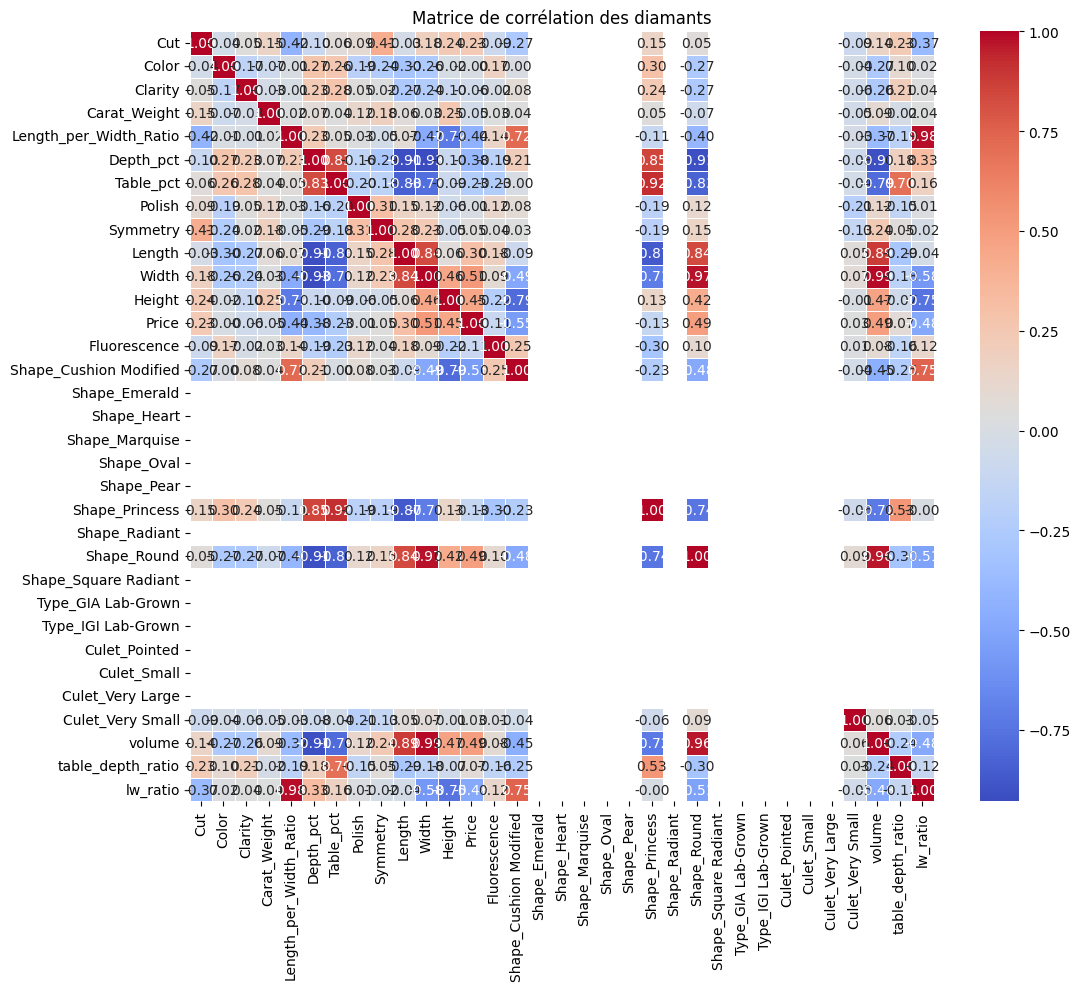

In [68]:
dfCorr = df.drop(columns=['Girdle_Extremely Thin to Extremely Thick','Girdle_Extremely Thin to Medium','Girdle_Extremely Thin to Slightly Thick', 'Girdle_Medium','Girdle_Medium to Extremely Thick',
        'Girdle_Medium to Slightly Thick','Girdle_Medium to Thick', 
        'Girdle_Medium to Very Thick','Girdle_Slightly Thick', 'Girdle_Slightly Thick to Extremely Thick','Girdle_Slightly Thick to Slightly Thick',
        'Girdle_Slightly Thick to Thick', 'Girdle_Slightly Thick to Very Thick',
        'Girdle_Thick', 'Girdle_Thick to Extremely Thick',
        'Girdle_Thick to Very Thick', 'Girdle_Thin',
        'Girdle_Thin to Extremely Thick', 'Girdle_Thin to Medium',
        'Girdle_Thin to Slightly Thick', 'Girdle_Thin to Thick',
        'Girdle_Thin to Very Thick', 'Girdle_Very Thick',
        'Girdle_Very Thick to Extremely Thick',
        'Girdle_Very Thin to Extremely Thick',
        'Girdle_Very Thin to Slightly Thick', 'Girdle_Very Thin to Thick',
        'Girdle_Very Thin to Very Thick'])
corr_matrix = dfCorr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation des diamants")
plt.show()

C:\Users\lepot\AppData\Local\Temp\ipykernel_19568\1555163792.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_plot, x='cut_label', order=order, palette='viridis')


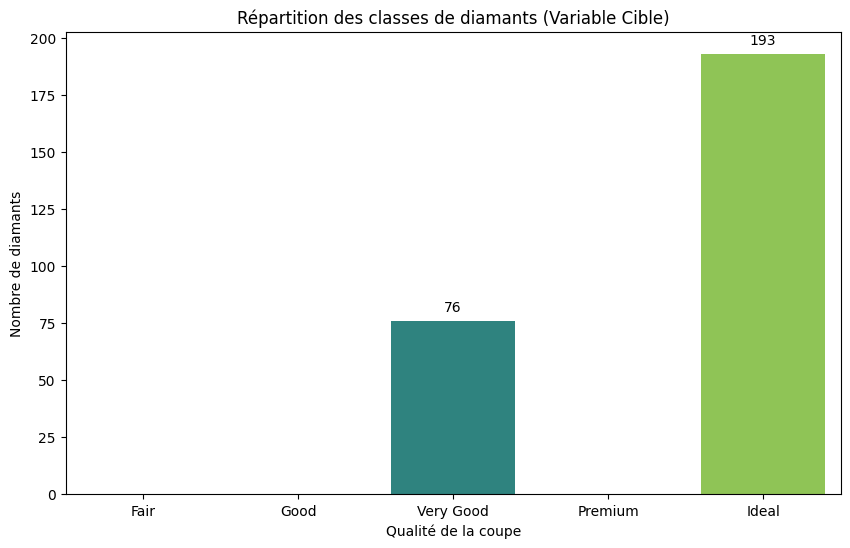

In [69]:
df_plot = df.copy()
inv_cut_map = {0: 'Fair', 1: 'Good', 2: 'Very Good', 3: 'Premium', 4: 'Ideal'}
df_plot['cut_label'] = df_plot['Cut'].map(inv_cut_map)

plt.figure(figsize=(10, 6))
order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] 
ax = sns.countplot(data=df_plot, x='cut_label', order=order, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Répartition des classes de diamants (Variable Cible)')
plt.xlabel('Qualité de la coupe')
plt.ylabel('Nombre de diamants')
plt.show()

## Préparation des données 

In [70]:
target = 'Color'
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_cat = to_categorical(y_train, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)


## Modèle Decision Tree

In [71]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

y_pred_train = tree_classifier.predict(X_train)
y_pred_test = tree_classifier.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy train : {accuracy_train:.2f}")
print(f"Accuracy test: {accuracy_test:.2f}")

Accuracy train : 1.00
Accuracy test: 0.56


## Modèle TensorFlow

In [72]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(7, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

model.summary()

c:\Users\lepot\Documents\deepLearnin\deep_learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,015 (230.53 KB)

 Trainable params: 58,119 (227.03 KB)

 Non-trainable params: 896 (3.50 KB)

## Entraînement

In [73]:
classes_uniques = np.unique(y_train)
poids = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_uniques,
    y=y_train
)
poids_dict = dict(zip(classes_uniques, poids))

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, 
    y_train_cat, 
    epochs=50, 
    batch_size=64, 
    validation_data=(X_test_scaled, y_test_cat),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=poids_dict,
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1488 - loss: 2.2920 - precision: 0.1389 - recall: 0.0465 - val_accuracy: 0.2037 - val_loss: 1.8897 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1674 - loss: 2.8953 - precision: 0.1842 - recall: 0.0651 - val_accuracy: 0.2778 - val_loss: 1.8758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1953 - loss: 2.0626 - precision: 0.2716 - recall: 0.1023 - val_accuracy: 0.3333 - val_loss: 1.8673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2326 - loss: 2.5348 - precision: 0.2394 - recall: 0.0791 - val_accuracy: 0.3333 - val_loss: 1.8633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/

## Évaluation et Résultats

Test Accuracy : 0.4444
Test Precision: 0.5000
Test Recall   : 0.0370
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EE8006E980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (5).

<Figure size 1000x800 with 0 Axes>

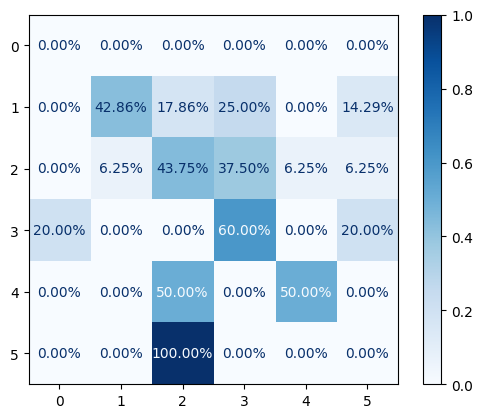

In [74]:
loss, acc, prec, rec = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")

y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
disp.plot(cmap='Blues', values_format='.2%')
plt.title("Matrice de Confusion Normalisée")
plt.show()